# %% [markdown]
# # CI/CD Energy Benchmark – Analysis Notebook
# 
# This notebook loads your PetClinic CI/CD deploy benchmark, computes comparison metrics,
# and generates publication-ready tables and charts.


In [ ]:
# %%
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import dedent
from pathlib import Path

# Make plots inline
%matplotlib inline

# Output directory
out_dir = Path("eco_ci_downloaded_results")
out_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
# %% [markdown]
# ## 2. Load Data

# %%
file_path = r"C:\Users\boubouthiam.niang\workspace\bl\eco-conception\petclinic-ci-cd-energy-benchmark\petclinic\analysis\data\raw\merged-eco-ci-petclinic-benchmark-deploy.xlsx"

df = pd.read_excel(file_path)

# Check the first rows
df.head()


,Run,Pipeline Reference,Target,Destination,avg. CPU utilization [%],Total Energy [Joules],avg. Power [Watts],Duration [Seconds]
0,1,1,Docker Container (No Cache),Local runner,36.3855,394.697,4.15471,97
1,1,2,Docker Container (Cached),Local runner,15.8349,619.196,2.65749,236
2,1,3,Dockerhub,Registry,17.4137,437.034,2.78365,159
3,1,4,Ghcr,Registry,12.5602,562.611,2.44614,233
4,1,5,kind cluster,Local runner,33.9165,307.078,3.88706,80


In [7]:
# %% [markdown]
# ## 3. Clean & Prepare Data

# %%
# Normalize column names
df.columns = [c.strip().replace(" ", "_").replace(".", "")
              .replace("[%]","pct").replace("[Joules]","J")
              .replace("[Watts]","W").replace("[Seconds]","s") 
              for c in df.columns]

# Convert numeric columns
num_cols = ["Run","Pipeline_Reference","avg_CPU_utilization_pct",
            "Total_Energy_J","avg_Power_W","Duration_s"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")

# Derived metrics
df["Energy_per_min_J"] = df["Total_Energy_J"] / (df["Duration_s"]/60.0)
df["J_per_%CPU"] = df["Total_Energy_J"] / df["avg_CPU_utilization_pct"]
df["Energy_Intensity_J_per_s"] = df["Total_Energy_J"] / df["Duration_s"]

df.head()


,Run,Pipeline_Reference,Target,Destination,avg_CPU_utilization_pct,Total_Energy_J,avg_Power_W,Duration_s,Energy_per_min_J,J_per_%CPU,Energy_Intensity_J_per_s
0,1,1,Docker Container (No Cache),Local runner,36.3855,394.697,4.15471,97,244.142474,10.847645,4.069041
1,1,2,Docker Container (Cached),Local runner,15.8349,619.196,2.65749,236,157.422712,39.103247,2.623712
2,1,3,Dockerhub,Registry,17.4137,437.034,2.78365,159,164.918491,25.097136,2.748642
3,1,4,Ghcr,Registry,12.5602,562.611,2.44614,233,144.878369,44.793156,2.414639
4,1,5,kind cluster,Local runner,33.9165,307.078,3.88706,80,230.308500,9.053941,3.838475


In [ ]:
# %% [markdown]
# ## 4. Summary by Target

# %%
summary_target = (
    df.groupby("Target")
      .agg(
          runs=("Run","count"),
          mean_energy_J=("Total_Energy_J","mean"),
          std_energy_J=("Total_Energy_J","std"),
          mean_power_W=("avg_Power_W","mean"),
          mean_duration_s=("Duration_s","mean"),
          mean_cpu_pct=("avg_CPU_utilization_pct","mean")
      )
      .sort_values("mean_energy_J")
      .reset_index()
)
summary_target


,Target,runs,mean_energy_J,std_energy_J,mean_power_W,mean_duration_s,mean_cpu_pct
0,k3d cluster,5,241.4528,31.224499,4.195624,60.4,39.24714
1,kind cluster,5,310.5890,5.695380,3.882272,82.0,33.95668
2,k3s cluster,5,314.4010,30.146060,3.331606,96.4,25.42752
3,Ghcr,5,387.4490,109.652973,3.469940,125.2,27.33178
4,Microk8s,5,405.1780,17.796836,3.567678,115.8,28.41880
5,Dockerhub,5,435.1636,72.100631,2.946664,153.8,19.38158
6,Docker Container (No Cache),5,478.0578,76.496961,3.516308,146.2,27.75898
7,Docker Container (Cached),5,525.5076,86.866016,3.118610,180.0,22.53112


In [9]:
# %% [markdown]
# ## 6. Rankings

# %%
def rank_table(metric_col, ascending=True, label=None):
    tb = (df.groupby("Target")[metric_col]
            .mean()
            .sort_values(ascending=ascending)
            .reset_index())
    tb.columns = ["Target", label or metric_col]
    return tb

rank_energy = rank_table("Total_Energy_J", ascending=True, label="Mean Energy [J]")
rank_duration = rank_table("Duration_s", ascending=True, label="Mean Duration [s]")
rank_power = rank_table("avg_Power_W", ascending=True, label="Mean Power [W]")

rank_energy, rank_duration, rank_power


(                        Target  Mean Energy [J]
 0                  k3d cluster         241.4528
 1                 kind cluster         310.5890
 2                  k3s cluster         314.4010
 3                         Ghcr         387.4490
 4                     Microk8s         405.1780
 5                    Dockerhub         435.1636
 6  Docker Container (No Cache)         478.0578
 7    Docker Container (Cached)         525.5076,
                         Target  Mean Duration [s]
 0                  k3d cluster               60.4
 1                 kind cluster               82.0
 2                  k3s cluster               96.4
 3                     Microk8s              115.8
 4                         Ghcr              125.2
 5  Docker Container (No Cache)              146.2
 6                    Dockerhub              153.8
 7    Docker Container (Cached)              180.0,
                         Target  Mean Power [W]
 0                    Dockerhub        2.946664
 1

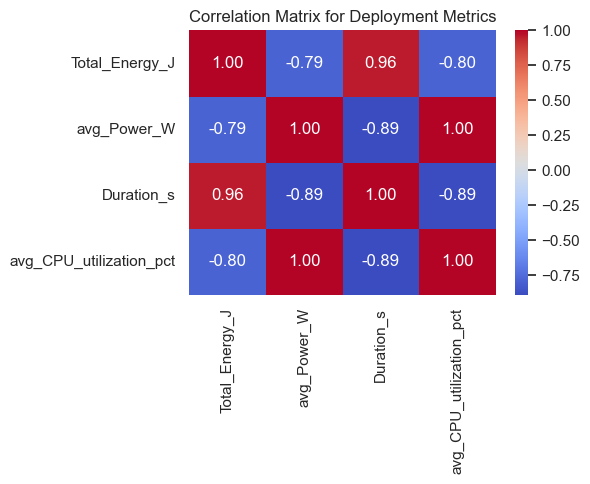

In [ ]:

corr = df[["Total_Energy_J","avg_Power_W","Duration_s","avg_CPU_utilization_pct"]].corr(method="pearson")

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix for Deployment Metrics")
plt.tight_layout()
plt.savefig("./eco_ci_downloaded_results/correlation_matrix.pdf")  # <-- saves as PDF
plt.show()


C:\Users\boubouthiam.niang\AppData\Local\Temp\ipykernel_22692\3939862402.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


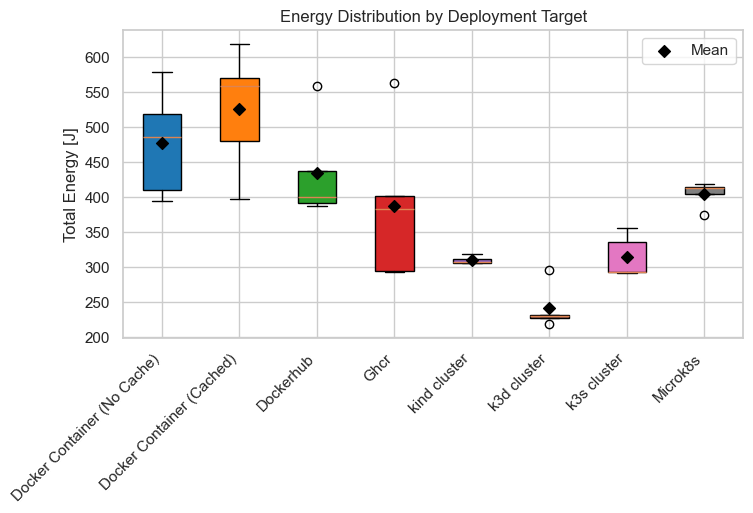

In [ ]:
targets = df["Target"].unique()
data = [df.loc[df["Target"] == t, "Total_Energy_J"].values for t in targets]

plt.figure(figsize=(8,4))
box = plt.boxplot(
    data, labels=targets, vert=True, patch_artist=True  # allow coloring
)

# Pick a colormap
colors = plt.cm.tab10.colors  

# Color each box
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

# Add mean markers
for i, d in enumerate(data, start=1):
    mean_val = np.mean(d)
    plt.scatter(i, mean_val, color='black', marker='D', zorder=3, label='Mean' if i==1 else "")

plt.ylabel("Total Energy [J]")
plt.title("Energy Distribution by Deployment Target")
plt.xticks(rotation=45, ha="right")
plt.legend()  # show legend for mean
plt.savefig("./eco_ci_downloaded_results/energy-boxplot.pdf")  
plt.show()


C:\Users\boubouthiam.niang\AppData\Local\Temp\ipykernel_22692\730243325.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=targets, vert=True, patch_artist=True)


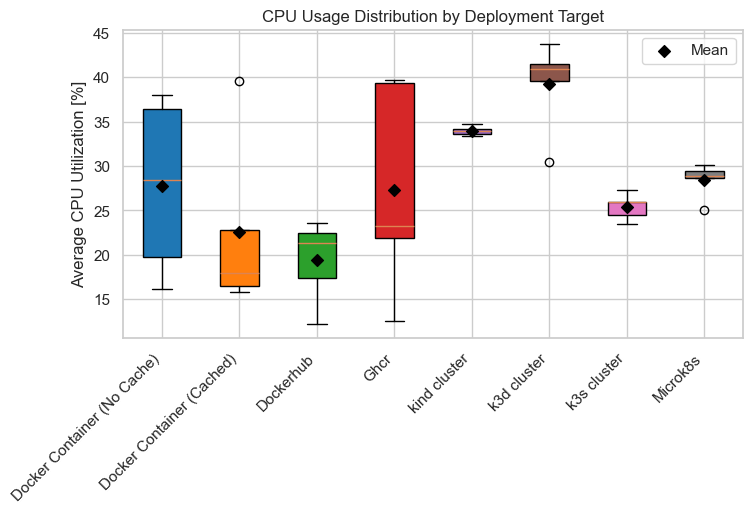

In [ ]:
targets = df["Target"].unique()
data = [df.loc[df["Target"] == t, "avg_CPU_utilization_pct"].values for t in targets]

plt.figure(figsize=(8,4))
box = plt.boxplot(data, labels=targets, vert=True, patch_artist=True)

colors = plt.cm.tab10.colors  
for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

# Add mean markers
for i, d in enumerate(data, start=1):
    mean_val = np.mean(d)
    plt.scatter(i, mean_val, color='black', marker='D', zorder=3, label='Mean' if i==1 else "")

plt.ylabel("Average CPU Utilization [%]")
plt.title("CPU Usage Distribution by Deployment Target")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.savefig("./eco_ci_downloaded_results/cpu-boxplot-deploy.pdf")
plt.show()


C:\Users\boubouthiam.niang\AppData\Local\Temp\ipykernel_22692\1694948146.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=targets, vert=True, patch_artist=True)


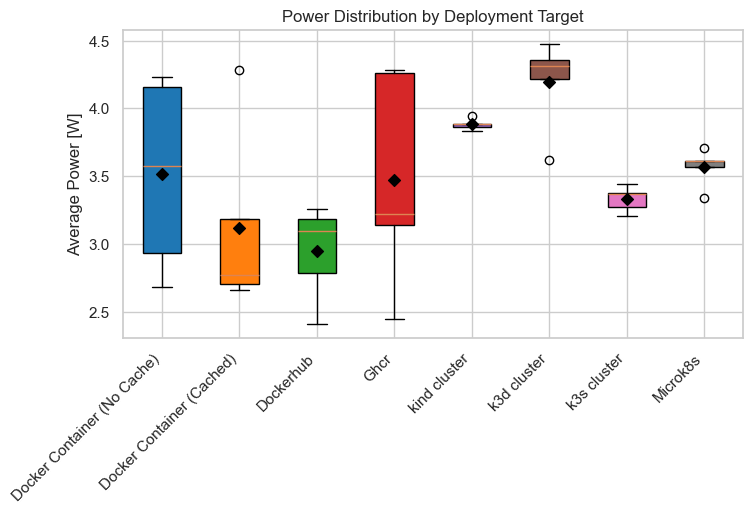

In [ ]:
data = [df.loc[df["Target"] == t, "avg_Power_W"].values for t in targets]

plt.figure(figsize=(8,4))
box = plt.boxplot(data, labels=targets, vert=True, patch_artist=True)

for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

for i, d in enumerate(data, start=1):
    mean_val = np.mean(d)
    plt.scatter(i, mean_val, color='black', marker='D', zorder=3)

plt.ylabel("Average Power [W]")
plt.title("Power Distribution by Deployment Target")
plt.xticks(rotation=45, ha="right")
plt.savefig("./eco_ci_downloaded_results/power-boxplot-deploy.pdf")
plt.show()


C:\Users\boubouthiam.niang\AppData\Local\Temp\ipykernel_22692\2651466359.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=targets, vert=True, patch_artist=True)


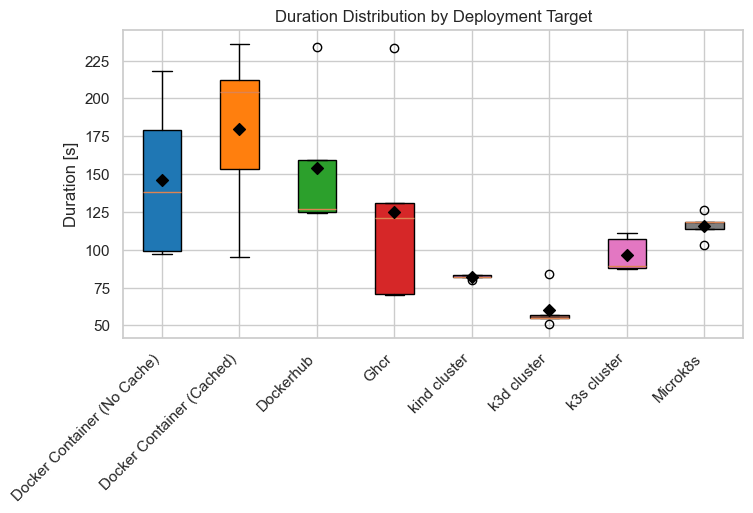

In [ ]:
data = [df.loc[df["Target"] == t, "Duration_s"].values for t in targets]

plt.figure(figsize=(8,4))
box = plt.boxplot(data, labels=targets, vert=True, patch_artist=True)

for patch, color in zip(box["boxes"], colors):
    patch.set_facecolor(color)

for i, d in enumerate(data, start=1):
    mean_val = np.mean(d)
    plt.scatter(i, mean_val, color='black', marker='D', zorder=3)

plt.ylabel("Duration [s]")
plt.title("Duration Distribution by Deployment Target")
plt.xticks(rotation=45, ha="right")
plt.savefig("./eco_ci_downloaded_results/duration-boxplot-deploy.pdf")
plt.show()


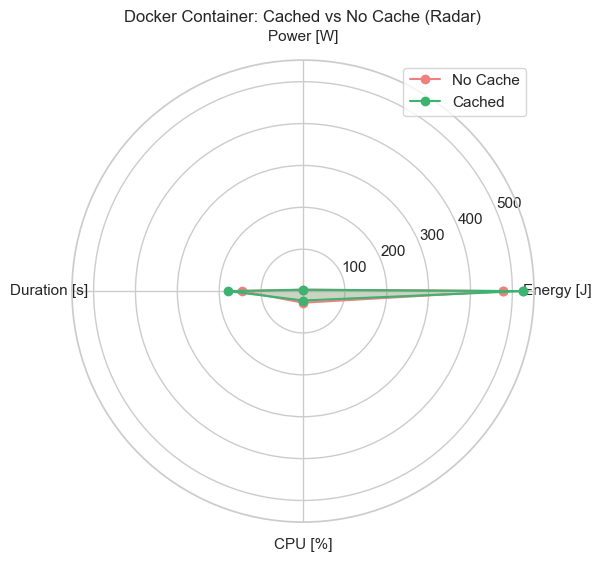

In [ ]:
metrics = ["Energy [J]", "Power [W]", "Duration [s]", "CPU [%]"]
N = len(metrics)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the circle

cached_values = docker_comp.loc["Docker Container (Cached)", ["mean_energy_J","mean_power_W","mean_duration_s","mean_cpu_pct"]].values.tolist()
nocache_values = docker_comp.loc["Docker Container (No Cache)", ["mean_energy_J","mean_power_W","mean_duration_s","mean_cpu_pct"]].values.tolist()
cached_values += cached_values[:1]
nocache_values += nocache_values[:1]

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
ax.plot(angles, nocache_values, 'o-', label="No Cache", color="lightcoral")
ax.fill(angles, nocache_values, alpha=0.25, color="lightcoral")
ax.plot(angles, cached_values, 'o-', label="Cached", color="mediumseagreen")
ax.fill(angles, cached_values, alpha=0.25, color="mediumseagreen")
ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
ax.set_title("Docker Container: Cached vs No Cache (Radar)")
ax.legend(loc="upper right")
plt.show()

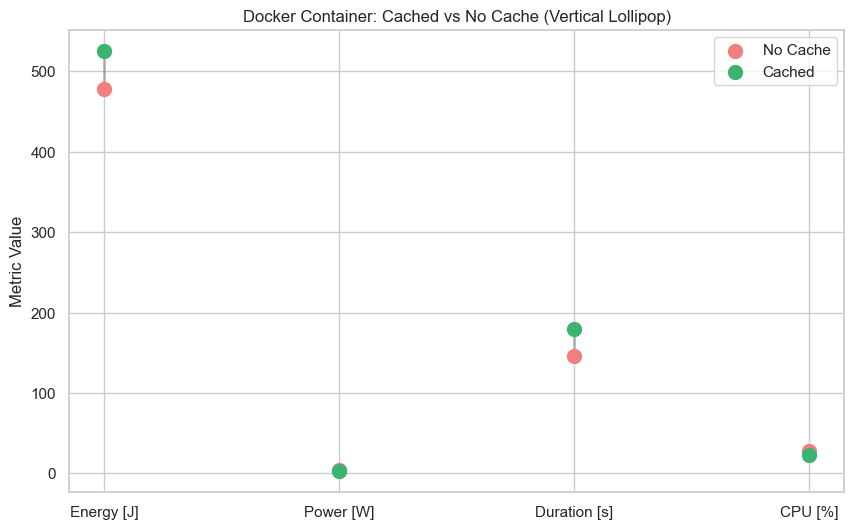

In [ ]:
metrics = ["Energy [J]", "Power [W]", "Duration [s]", "CPU [%]"]
cached_values = docker_comp.loc["Docker Container (Cached)", ["mean_energy_J","mean_power_W","mean_duration_s","mean_cpu_pct"]].values
nocache_values = docker_comp.loc["Docker Container (No Cache)", ["mean_energy_J","mean_power_W","mean_duration_s","mean_cpu_pct"]].values

x = np.arange(len(metrics))

plt.figure(figsize=(10,6))
plt.vlines(x, nocache_values, cached_values, color='gray', alpha=0.5, linewidth=2)
plt.scatter(x, nocache_values, label="No Cache", color="lightcoral", s=100, zorder=3)
plt.scatter(x, cached_values, label="Cached", color="mediumseagreen", s=100, zorder=3)

plt.xticks(x, metrics)
plt.ylabel("Metric Value")
plt.title("Docker Container: Cached vs No Cache (Vertical Lollipop)")
plt.legend()
plt.savefig("./eco_ci_downloaded_results/docker-lollipop-deploy.pdf")
plt.show()